# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,no-book-author,609392,NaN
1,LOC-MDS,no-author-rec,310413,NaN
2,LOC-MDS,no-gender,4314710,NaN
3,BX-I,no-book-author,11351,20423.0
4,BX-I,no-book,40631,56193.0


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,NaN,NaN,NaN,NaN,135014.0,179826.0,911746.0,1226586.0
BX-E,NaN,NaN,NaN,NaN,5433.0,5615.0,20073.0,31121.0
BX-I,NaN,NaN,NaN,NaN,10946.0,11351.0,40631.0,62928.0
GR-E,NaN,NaN,NaN,NaN,48542.0,786747.0,NaN,835289.0
GR-I,NaN,NaN,NaN,NaN,48542.0,786747.0,NaN,835289.0
LOC-MDS,NaN,NaN,NaN,NaN,310413.0,609392.0,NaN,919805.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,NaN,NaN,NaN,NaN,900009.0,2662295.0,4211633.0
BX-E,NaN,NaN,NaN,NaN,6932.0,7616.0,23059.0
BX-I,NaN,NaN,NaN,NaN,18035.0,20423.0,56193.0
GR-E,NaN,NaN,NaN,NaN,950826.0,12291358.0,NaN
GR-I,NaN,NaN,NaN,NaN,950826.0,12291358.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,NaN,NaN,NaN,NaN,0.110073,0.146607,0.743320
BX-E,NaN,NaN,NaN,NaN,0.174577,0.180425,0.644999
BX-I,NaN,NaN,NaN,NaN,0.173945,0.180381,0.645674
GR-E,NaN,NaN,NaN,NaN,0.058114,0.941886,NaN
GR-I,NaN,NaN,NaN,NaN,0.058114,0.941886,NaN
LOC-MDS,NaN,NaN,NaN,NaN,0.337477,0.662523,NaN


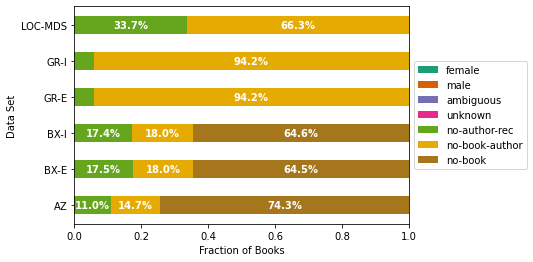

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,NaN,NaN,NaN,NaN,1.0
BX-E,NaN,NaN,NaN,NaN,1.0
BX-I,NaN,NaN,NaN,NaN,1.0
GR-E,NaN,NaN,NaN,NaN,1.0
GR-I,NaN,NaN,NaN,NaN,1.0
LOC-MDS,NaN,NaN,NaN,NaN,1.0


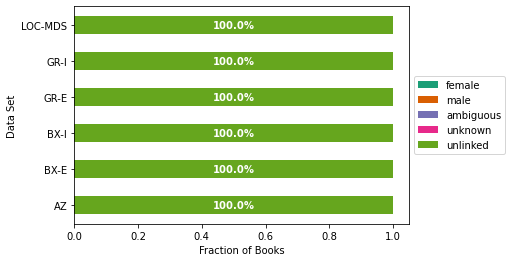

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

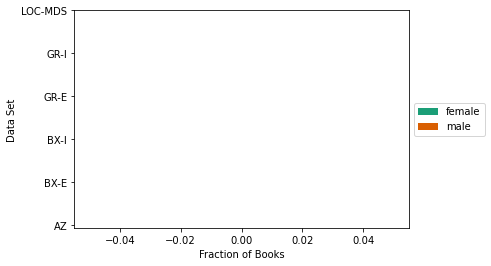

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,NaN,NaN,NaN,NaN,0.115773,0.342464,0.541763
BX-E,NaN,NaN,NaN,NaN,0.184327,0.202515,0.613157
BX-I,NaN,NaN,NaN,NaN,0.190542,0.215772,0.593686
GR-E,NaN,NaN,NaN,NaN,0.071803,0.928197,NaN
GR-I,NaN,NaN,NaN,NaN,0.071803,0.928197,NaN


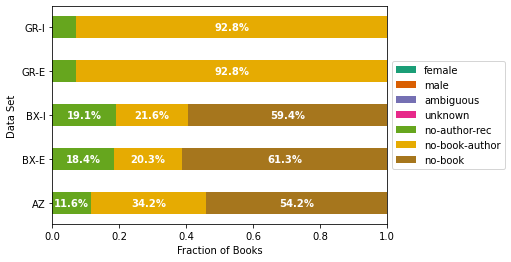

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,NaN,NaN,NaN,NaN,1.0
BX-E,NaN,NaN,NaN,NaN,1.0
BX-I,NaN,NaN,NaN,NaN,1.0
GR-E,NaN,NaN,NaN,NaN,1.0
GR-I,NaN,NaN,NaN,NaN,1.0


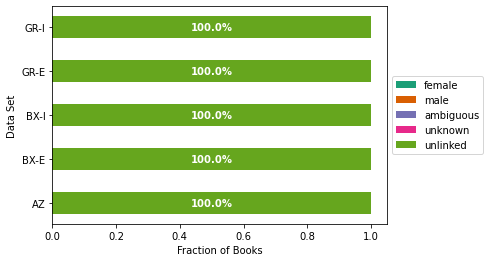

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

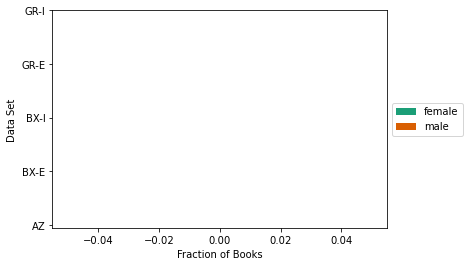

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ        NaN
BX-E      NaN
BX-I      NaN
GR-E      NaN
GR-I      NaN
LOC-MDS   NaN
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')